In [1]:
%load_ext autoreload
%autoreload 1
%aimport myutils

In [2]:
import joblib
import sys

import hiclass
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.ensemble import GradientBoostingClassifier

print('python:'.ljust(16), sys.version.split('\n')[0])
print('hiclass:'.ljust(16), hiclass.__version__)
print('scikit-learn:'.ljust(16), sklearn.__version__)

python:          3.9.12 (main, Apr  5 2022, 01:53:17) 
hiclass:         3.0.3
scikit-learn:    1.0.2


## Define constants

In [3]:
RANDOM_SEED = 2147483647
GRAPH_ROOT = 1

DATA_PATH = './data/'
WORKING_PATH = myutils.WORKING_PATH

IDENT = 'id'  # ID feature name
TARGET = myutils.TARGET  # Target feature name
TRAIN = myutils.TRAIN  # Binary feature name to separate train and test data
PATH_COLS = myutils.PATH_COLS
RANDOM = 'RANDOM'  # Feature of random numbers

MODEL_TYPE = 'lcpn'  # {'lcpn', 'lcn'}
N_ESTIMATORS = 20
N_WORD_SYMBOLS = 2
VALID_SIZE = 0.2

## Load data

In [4]:
# Load datasets
tree = pd.read_csv(DATA_PATH + 'categories_tree.csv')
df_train = pd.read_parquet(DATA_PATH + 'train.parquet', 'pyarrow')
df_test = pd.read_parquet(DATA_PATH + 'test.parquet', 'pyarrow')

# Join train and test datasets
df_test[TARGET] = pd.NA  # Fill target variable of the test dataset with zeros
df_train[TRAIN] = True  # Train/test flag
df_test[TRAIN] = False  # Train/test flag
df = pd.concat([df_train, df_test], ignore_index=True)

## Prepare graph

In [5]:
# Define graph
edgelist = [tuple(r) for r in tree[['parent_id', 'id']].to_numpy()]
G = nx.from_edgelist(edgelist, create_using=nx.DiGraph)

# Remove nodes that not in df
G.remove_node(0)
print('Number of deleted nodes:')
df_leaf_nodes = set(df.loc[df[TRAIN], TARGET])
while True:
    graph_leaf_nodes = {x for x in G.nodes() if G.out_degree(x)==0}
    useless_nodes = graph_leaf_nodes - df_leaf_nodes
    print(len(useless_nodes))
    if len(useless_nodes) == 0:
        break
    G.remove_nodes_from(useless_nodes)

Number of deleted nodes:
1615
228
42
10
1
0


## Prepare dataframe
### Preprocess

In [6]:
# Add binary column to indicate rating absence (0.0 value)
df['no_rating'] = 0
df.loc[df['rating'] == 0.0, 'no_rating'] = 1

# Replace 0.0 rating with mean value
mean_rating = df.loc[df['rating'] == 0.0, 'rating'].mean()
df.loc[df['rating'].isna(), 'rating'] = mean_rating

# Replace -1 value of feedback quantity with 0
df.loc[df['feedback_quantity'] == -1, 'feedback_quantity'] = 0

# Add feature with random numbers
rng = np.random.default_rng(RANDOM_SEED)
df[RANDOM] = rng.integers(1000000, size=len(df))

# Drop features that will not be used
df.drop(['short_description', 'name_value_characteristics'], axis=1, inplace=True)

### Add columns with path nodes

In [7]:
path_maps = myutils.get_path_map_by_depth(G, GRAPH_ROOT)

path_map_df = pd.DataFrame.from_dict(
    path_maps[-1],
    orient='index',
    dtype=pd.Int64Dtype(),
    columns=PATH_COLS,
)

df = df.join(path_map_df, on=TARGET)

### View df

In [8]:
df.head(2)

,id,title,rating,feedback_quantity,category_id,TRAIN,no_rating,RANDOM,node_1,node_2,node_3,node_4,node_5
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,0.000000,0,2693,True,1,815807,10012,10113,10355,2693,-1
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",4.666667,9,13408,True,0,270854,10020,10044,10398,13408,-1


### Split df on train, valid, test

In [9]:
# Split df
X, X_train, X_valid, X_test, y, y_train, y_valid, _, _ = myutils.split_scale_df(
    df, validation_size=VALID_SIZE, random_state=RANDOM_SEED
)

# Print shapes
pd.DataFrame({'X': {'not test': X.shape, 'train': X_train.shape, 'valid': X_valid.shape, 'test': X_test.shape},
              'y': {'not test': y.shape, 'train': y_train.shape, 'valid': y_valid.shape, 'test': None}})

,X,y
not test,"(283452, 6)","(283452, 5)"
train,"(226761, 6)","(226761, 5)"
valid,"(56691, 6)","(56691, 5)"
test,"(70864, 6)",None


### Vectorize 'title' column

In [10]:
%%time
# Get vectorizer
vectorizer = myutils.get_vectorizer(
    X_train['title'],
    'bl_vectorizer_w' + str(N_WORD_SYMBOLS) + '_train.joblib',
    r'(?u)\b\w{' + str(N_WORD_SYMBOLS) + r',}\b',
)

print('Number of vectorized features:', len(vectorizer.vocabulary_))
print()

Number of vectorized features: 26155

CPU times: user 139 ms, sys: 10.8 ms, total: 150 ms
Wall time: 149 ms


In [11]:
%%time
# Get 'title' vectors
title_train = myutils.get_title_vectors(
    X_train['title'],
    'bl_titlevect_w' + str(N_WORD_SYMBOLS) + '_train.joblib',
    vectorizer,
)
title_valid = myutils.get_title_vectors(
    X_valid['title'],
    'bl_titlevect_w' + str(N_WORD_SYMBOLS) + '_valid.joblib',
    vectorizer,
)
title_whole = myutils.get_title_vectors(
    X['title'],
    'bl_titlevect_w' + str(N_WORD_SYMBOLS) + '_whole.joblib',
    vectorizer,
)
title_test = myutils.get_title_vectors(
    X_test['title'],
    'bl_titlevect_w' + str(N_WORD_SYMBOLS) + '_test.joblib',
    vectorizer,
)

# Add other columns from df
columns = [RANDOM, IDENT, 'rating', 'no_rating', 'feedback_quantity']
X_train = scipy.sparse.hstack((title_train, X_train[columns].values))
X_valid = scipy.sparse.hstack((title_valid, X_valid[columns].values))
X = scipy.sparse.hstack((title_whole, X[columns].values))
X_test = scipy.sparse.hstack((title_test, X_test[columns].values))


# Print shapes
pd.DataFrame({'X': {'train': X_train.shape, 'valid': X_valid.shape, 'whole': X.shape, 'test': X_test.shape},
              'y': {'train': y_train.shape, 'valid': y_valid.shape, 'whole': y.shape, 'test': None}})

CPU times: user 115 ms, sys: 38.9 ms, total: 154 ms
Wall time: 154 ms


,X,y
train,"(226761, 26160)","(226761, 5)"
valid,"(56691, 26160)","(56691, 5)"
whole,"(283452, 29421)","(283452, 5)"
test,"(70864, 29421)",None


## Define classifier and fit

In [27]:
%%time
clf = GradientBoostingClassifier(
    n_estimators=1000,
    max_features='sqrt',
    random_state=RANDOM_SEED,
)

clf.fit(X_train, y_train[:, 0])

CPU times: user 4min 13s, sys: 454 ms, total: 4min 13s
Wall time: 4min 13s


GradientBoostingClassifier(max_features='sqrt', n_estimators=1000,
                           random_state=2147483647)

## Predict

In [28]:
%%time
pred_train = clf.predict(X_train)
pred_valid = clf.predict(X_valid)
print()

pred_valid


CPU times: user 10.6 s, sys: 19.1 ms, total: 10.6 s
Wall time: 10.6 s


array([10014, 10020, 10012, ..., 10012, 10020, 10018])

## Compute metric

In [29]:
whF_train, _ = myutils.get_score(path_maps[0], y_train[:, :1], pred_train[:, None])
whF_valid, _ = myutils.get_score(path_maps[0], y_valid[:, :1], pred_valid[:, None])
print()
print('Weighted hF on train:', whF_train)
print('Weighted hF on valid:', whF_valid)

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 887.61it/s]



Weighted hF on train: 0.972589413699061
Weighted hF on valid: 0.9673111551946982


## Feature selection

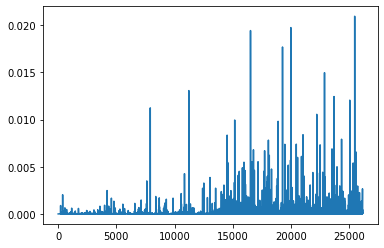

In [30]:
f_imp = pd.Series(clf.feature_importances_)
f_imp.plot();

In [62]:
random_feature_index = -5
importance_devider = 2

random_feature_importance = f_imp.iat[random_feature_index]
feature_mask = (f_imp > random_feature_importance / importance_devider)

print('Number of important features:', feature_mask.sum())

Number of important features: 1736


In [55]:
f_imp.loc[feature_mask]

208      0.000329
209      0.000887
211      0.000039
222      0.000029
249      0.000020
           ...   
26155    0.000040
26156    0.002660
26157    0.000182
26158    0.000037
26159    0.000392
Length: 1736, dtype: float64

In [63]:
joblib.dump(feature_mask, WORKING_PATH + 'lvl1_feature_mask.joblib')

['./working/lvl1_feature_mask.joblib']